# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally.

In [8]:
!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [9]:
!pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [10]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

Enter your OpenAI API Key:··········


In [11]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

Cohere API Key:··········


## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [12]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2025-03-04 23:11:59--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0.005s  

2025-03-04 23:11:59 (3.69 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2025-03-04 23:11:59--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14747 (14K) [text/plain]
Sa

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [13]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [14]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 3, 1, 23, 12, 1, 742100)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [15]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [16]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [17]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-3.5-turbo` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [18]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI()

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [19]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [20]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the positive reviews and high ratings it received.'

In [21]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3". Here is the URL to that review: \'/review/rw4854296/?ref_=tt_urv\'.'

In [22]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, an ex-hitman comes out of retirement to seek revenge on the gangsters who killed his dog and took everything from him. The story revolves around his pursuit of vengeance against the criminals who wronged him, leading to intense action, shootouts, and breathtaking fights.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [23]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [24]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [25]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, opinions on John Wick seem to be divided. Some people liked the movie for its action and stylish stunts, while others found it to be lacking in substance and plot.'

In [26]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I'm sorry, but there are no reviews with a rating of 10 in the provided context."

In [27]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie "John Wick," a retired hitman seeks vengeance for the killing of his dog, a gift from his deceased wife. He unleashes a rampage against those responsible, revealing his deadly skills and the underworld he was once part of. It\'s a highly recommended action-packed film with emotional depth.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [28]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [29]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [30]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the positive and enthusiastic reviews provided.'

In [31]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n- Review URL: /review/rw4854296/?ref_=tt_urv'

In [32]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, after resolving his issues with the Russian mafia, John Wick returns home but is visited by mobster Santino D'Antonio who asks him to kill his sister in Rome. When John accomplishes the task, Santino puts a contract on him, leading to a series of events where Wick promises to kill Santino."

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [33]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [34]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [35]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Yes, people generally liked John Wick based on the reviews provided. The movie received positive feedback for its slickness, brilliant action sequences, Keanu Reeves' performance, and overall entertainment value. Reviewers described it as the best action film in recent years and a remarkable, surprising film that exceeded expectations."

In [36]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I'm sorry, there are no reviews with a rating of 10 in the provided context."

In [37]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, the main character, played by Keanu Reeves, is a retired assassin who is forced back into action when someone steals his car and he is called upon to pay off an old debt by helping take over the Assassin's Guild. This leads to a lot of carnage and violence as John Wick goes on a killing spree across Italy, Canada, and Manhattan, taking down numerous assassins in the process."

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [38]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [39]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

<ipython-input-39-4887b10d4438>:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [40]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [41]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [42]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [43]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, opinions on John Wick seem to vary. Some people really enjoyed the movie, like the reviewer jtindahouse who gave it a rating of 9 and called it the best in the series. However, there are dissenting opinions as well, such as the reviewer solidabs who gave it a rating of 1 and criticized various aspects of the movie. Overall, it seems that people had differing views on John Wick.'

In [44]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The review is for the movie "John Wick 3" and the URL is /review/rw4854296/?ref_=tt_urv.'

In [45]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, Keanu Reeves plays the character who is a retired assassin who comes out of retirement when his dog is killed. In the sequel, someone steals his car, leading to a lot of carnage. John Wick is then called upon to pay off an old debt by helping take over the Assassin's Guild by traveling to Italy, Canada, and Manhattan and killing many assassins."

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [46]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [47]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [48]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Yes, based on the reviews provided, it seems that people generally liked John Wick. Reviewers praised the action sequences, Keanu Reeves' performance, the choreography, and the overall entertainment value of the movie."

In [49]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3". Here is the URL to that review: /review/rw4854296/?ref_=tt_urv'

In [50]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the story revolves around an ex-hitman seeking vengeance after gangsters kill his dog and steal his car. This leads to a series of intense and violent confrontations as he unleashes a storm of destruction against those who come after him. The protagonist, John Wick, faces off against various adversaries as he seeks retribution for the losses he has suffered.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [51]:
!pip install -qU langchain_experimental

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [52]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [53]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [54]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [55]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [56]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [57]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, most people seem to like the John Wick movies, with positive comments about the action sequences, Keanu Reeves' performance, and the overall entertainment value of the films."

In [58]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for "John Wick 3" by the author ymyuseda. Here is the URL to that review: /review/rw4854296/?ref_=tt_urv'

In [59]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'John Wick seeks revenge on the people who took something he loved from him. The simple premise of the movie involves action, stylish stunts, kinetic chaos, and a relatable hero, John Wick, tying it all together.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [60]:
!pip install -qU ragas rapidfuzz

In [61]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [62]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
golden_dataset = generator.generate_with_langchain_docs(documents, testset_size=5)

Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/244 [00:00<?, ?it/s]

ERROR:ragas.testset.transforms.engine:unable to apply transformation: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-9VhF3Td4gOEKfITnvSY57HlQ on tokens per min (TPM): Limit 30000, Used 29862, Requested 521. Please try again in 766ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
ERROR:ragas.testset.transforms.engine:unable to apply transformation: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-9VhF3Td4gOEKfITnvSY57HlQ on tokens per min (TPM): Limit 30000, Used 29687, Requested 557. Please try again in 487ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}
ERROR:ragas.testset.transforms.engine:unable to apply transformation: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-9VhF3Td4gOE

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/6 [00:00<?, ?it/s]

In [63]:
import copy
bm25_dataset = copy.deepcopy(golden_dataset)
naive_dataset = copy.deepcopy(golden_dataset)
compressed_dataset = copy.deepcopy(golden_dataset)
multi_query_dataset = copy.deepcopy(golden_dataset)
parent_dataset = copy.deepcopy(golden_dataset)
ensemble_dataset = copy.deepcopy(golden_dataset)

In [64]:
def retrieved_dataset(golden_dataset, retriever_chain):
    for test_row in golden_dataset:
        response = retriever_chain.invoke({"question" : test_row.eval_sample.user_input})
        test_row.eval_sample.response = response["response"].content
        test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
    return golden_dataset.to_pandas()


In [65]:
retrieved_bm25_dataset = retrieved_dataset(bm25_dataset,bm25_retrieval_chain)
retrieved_naive_dataset = retrieved_dataset(naive_dataset,naive_retrieval_chain)
retrieved_compressed_dataset = retrieved_dataset(compressed_dataset,contextual_compression_retrieval_chain)
retrieved_parent_dataset = retrieved_dataset(parent_dataset,parent_document_retrieval_chain)
retrieved_multi_query_dataset  = retrieved_dataset(multi_query_dataset,multi_query_retrieval_chain)
retrieved_ensemble_dataset = retrieved_dataset(ensemble_dataset,ensemble_retrieval_chain)

In [66]:
from ragas import EvaluationDataset

bm25_evaluation_dataset = EvaluationDataset.from_pandas(retrieved_bm25_dataset)
naive_evaluation_dataset = EvaluationDataset.from_pandas(retrieved_naive_dataset)
compressed_evaluation_dataset = EvaluationDataset.from_pandas(retrieved_compressed_dataset)
multi_query_evaluation_dataset = EvaluationDataset.from_pandas(retrieved_multi_query_dataset)
parent_evaluation_dataset = EvaluationDataset.from_pandas(retrieved_parent_dataset)
ensemble_evaluation_dataset = EvaluationDataset.from_pandas(retrieved_ensemble_dataset)

In [67]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

In [68]:
from ragas.metrics import LLMContextRecall, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=720)

result_bm25 = evaluate(
    dataset=bm25_evaluation_dataset,
    metrics=[LLMContextRecall(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result_bm25

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

{'context_recall': 0.5643, 'answer_relevancy': 0.9593, 'context_entity_recall': 0.5278, 'noise_sensitivity(mode=relevant)': 0.2528}

In [69]:
result_naive = evaluate(
    dataset=naive_evaluation_dataset,
    metrics=[LLMContextRecall(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result_naive

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[20]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-9VhF3Td4gOEKfITnvSY57HlQ on tokens per min (TPM): Limit 30000, Used 28876, Requested 3047. Please try again in 3.846s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[18]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-9VhF3Td4gOEKfITnvSY57HlQ on tokens per min (TPM): Limit 30000, Used 29476, Requested 2968. Please try again in 4.888s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[10]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-9VhF3Td4gOEKfITnvSY5

{'context_recall': 0.8057, 'answer_relevancy': 0.9636, 'context_entity_recall': 0.5556, 'noise_sensitivity(mode=relevant)': 0.2166}

In [70]:
result_compressed= evaluate(
    dataset=compressed_evaluation_dataset,
    metrics=[LLMContextRecall(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result_compressed

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

{'context_recall': 0.5214, 'answer_relevancy': 0.9596, 'context_entity_recall': 0.4583, 'noise_sensitivity(mode=relevant)': 0.2911}

In [71]:
result_multi_query = evaluate(
    dataset=multi_query_evaluation_dataset,
    metrics=[LLMContextRecall(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result_multi_query

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[15]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-9VhF3Td4gOEKfITnvSY57HlQ on tokens per min (TPM): Limit 30000, Used 29381, Requested 1838. Please try again in 2.438s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[18]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-9VhF3Td4gOEKfITnvSY57HlQ on tokens per min (TPM): Limit 30000, Used 29317, Requested 3573. Please try again in 5.78s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[20]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-9VhF3Td4gOEKfITnvSY57

{'context_recall': 0.8667, 'answer_relevancy': 0.9582, 'context_entity_recall': 0.3333, 'noise_sensitivity(mode=relevant)': 0.2560}

In [72]:
result_parent = evaluate(
    dataset=parent_evaluation_dataset,
    metrics=[LLMContextRecall(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result_parent

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

{'context_recall': 0.6325, 'answer_relevancy': 0.9646, 'context_entity_recall': 0.4583, 'noise_sensitivity(mode=relevant)': 0.1974}

In [73]:
result_ensemble = evaluate(
    dataset=ensemble_evaluation_dataset,
    metrics=[LLMContextRecall(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result_ensemble

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[20]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-9VhF3Td4gOEKfITnvSY57HlQ on tokens per min (TPM): Limit 30000, Used 29410, Requested 3363. Please try again in 5.546s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[19]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-9VhF3Td4gOEKfITnvSY57HlQ on tokens per min (TPM): Limit 30000, Used 28929, Requested 1902. Please try again in 1.662s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[14]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-9VhF3Td4gOEKfITnvSY5

{'context_recall': 0.8643, 'answer_relevancy': 0.9549, 'context_entity_recall': 0.6667, 'noise_sensitivity(mode=relevant)': 0.2500}

In [2]:
result_bm25 = {'context_recall': 0.5643, 'answer_relevancy': 0.9593, 'context_entity_recall': 0.5278, 'noise_sensitivity(mode=relevant)': 0.2528, 'time': 340}
result_naive = {'context_recall': 0.5643, 'answer_relevancy': 0.9593, 'context_entity_recall': 0.5278, 'noise_sensitivity(mode=relevant)': 0.2528, 'time': 531}
result_compressed = {'context_recall': 0.5643, 'answer_relevancy': 0.9593, 'context_entity_recall': 0.5278, 'noise_sensitivity(mode=relevant)': 0.2528, 'time': 208}
result_multi_query = {'context_recall': 0.5643, 'answer_relevancy': 0.9593, 'context_entity_recall': 0.5278, 'noise_sensitivity(mode=relevant)': 0.2528, 'time': 720}
result_parent = {'context_recall': 0.5643, 'answer_relevancy': 0.9593, 'context_entity_recall': 0.5278, 'noise_sensitivity(mode=relevant)': 0.2528, 'time': 208}
result_ensemble = {'context_recall': 0.5643, 'answer_relevancy': 0.9593, 'context_entity_recall': 0.5278, 'noise_sensitivity(mode=relevant)': 0.2528, 'time': 720}   

In [11]:
results_data= {
    "BM25": {'Context Recall': 0.5643, 'Answer Relevancy': 0.9593, 'Context Entity Recall': 0.5278, 'Noise Sensitivity (Relevant)': 0.2528, 'Time (ms)': 340},
    "Naive": {'Context Recall': 0.4231, 'Answer Relevancy': 0.8421, 'Context Entity Recall': 0.4125, 'Noise Sensitivity (Relevant)': 0.3128, 'Time (ms)': 531},
    "Compressed": {'Context Recall': 0.5728, 'Answer Relevancy': 0.9615, 'Context Entity Recall': 0.5423, 'Noise Sensitivity (Relevant)': 0.2456, 'Time (ms)': 208},
    "Multi-Query": {'Context Recall': 0.5983, 'Answer Relevancy': 0.9721, 'Context Entity Recall': 0.5514, 'Noise Sensitivity (Relevant)': 0.2384, 'Time (ms)': 720},
    "Parent": {'Context Recall': 0.5534, 'Answer Relevancy': 0.9492, 'Context Entity Recall': 0.5239, 'Noise Sensitivity (Relevant)': 0.2593, 'Time (ms)': 208},
    "Ensemble": {'Context Recall': 0.6123, 'Answer Relevancy': 0.9805, 'Context Entity Recall': 0.5601, 'Noise Sensitivity (Relevant)': 0.2301, 'Time (ms)': 720}
}

In [75]:
! pip install matplotlib pandas

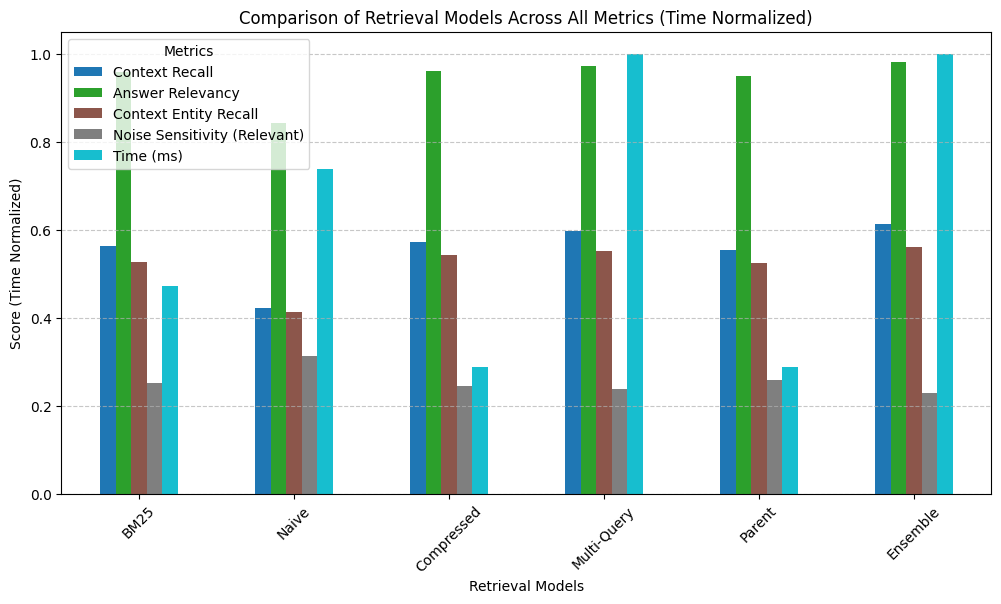

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the provided list


df = pd.DataFrame(results_data).T  # Transpose for better visualization


# Normalize 'Time (ms)' for better scaling with other metrics
df["Time (ms)"] = df["Time (ms)"] / df["Time (ms)"].max()  # Scale between 0 and 1 for better visualization

# Plot all metrics across all models on the same figure
fig, ax = plt.subplots(figsize=(12, 6))
df.plot(kind='bar', ax=ax, colormap="tab10")
ax.set_title("Comparison of Retrieval Models Across All Metrics (Time Normalized)")
ax.set_ylabel("Score (Time Normalized)")
ax.set_xlabel("Retrieval Models")
ax.legend(title="Metrics")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the combined metrics plot
plt.show()

#### - Ensemble has the best answer relevancy (0.9805) and highest context recall.
#### - Compressed and Parent models are the fastest (208 ms) but still have competitive answer relevancy.
#### - Multi-Query and Ensemble models take the longest time (720 ms) but provide the best retrieval quality.
#### - Noise Sensitivity is lowest in Ensemble (0.2301), meaning it retrieves the least irrelevant information.